# NTL9 <br>



Before starting, remember to activate the environment:  <br>
**source env/extra/activate**





In [1]:
from md_intrinsic_dimension import intrinsic_dimension, section_id, secondary_structure_id
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import seaborn as sns
import logging
from moleculekit.molecule import Molecule

#build personalised cmap
colors = mpl.colors.ListedColormap(
    name="discrete-bicolor",
    colors=["#e9ff99","#ceff29", "#A5CC21", "#C099F3", "#6100e0", "#4E00B3"])


#set font dimension
plt.rcParams.update({
	'axes.titlesize': 13,
	'axes.labelsize': 13,
	'xtick.labelsize': 11,
	'ytick.labelsize': 11,
	'legend.fontsize': 11,
	'legend.title_fontsize': 13,
	'lines.linewidth' : 1,
	'lines.markersize': 8,
})

To provide examples of ID applications, we used trajectories of fast folding proteins generated by D. E. Shaw group ([DOI:10.1126/science.1208351](https://pubmed.ncbi.nlm.nih.gov/22034434/)). 

In particular, we used N-terminal Domain of Ribosomal Protein L9 (NTL9, PDB: 2HBA), a 52 residue long protein with a single point mutation, K12M, to increase its stability by 1.9 kcal mol<sup>−1</sup> .  

We used protein structure and trajectory data of DESRES-Trajectory_NTL9-2-protein. 
We sampled the originally simulated trajectory in 6 shorter sub-trajectories of 2000 frames each, representing either the folded state of the protein (f0, f1, f2) or the unfolded one (u0, u1, u2).
| Original Trajectory    | New Trajectory | Frames    | State |
|------------------------|----------------|-----------|-------|
|NTL9-2-protein-000.dcd  |ntl9_u0.xtc     |[:2000]    | Unfolded |
|NTL9-2-protein-050.dcd  |ntl9_f0.xtc     |[:2000]    | Folded   |
|NTL9-2-protein-080.dcd  |ntl9_u1.xtc     |[:2000]    | Unfolded |
|NTL9-2-protein-100.dcd  |ntl9_f1.xtc     |[:2000]    | Folded   |
|NTL9-2-protein-124.dcd  |ntl9_u2.xtc     |[:2000]    | Unfolded |
|NTL9-2-protein-194.dcd  |ntl9_f2.xtc     |[:2000]    | Folded   |



In [17]:
topology='examples/NTL9/ntl9.pdb'
trajectory='examples/NTL9/ntl9'
protein = 'ntl9'

projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}

data = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 


for state in states:
    mean_all, mean_last, local_id = intrinsic_dimension(topology=topology, trajectory=trajectory+f'_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local', verbose=False)
	
    data.append({'trajectory': state,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
      'local_id': local_id,
      })
data = pd.DataFrame(data)
data["folded"] = data["trajectory"].str.startswith("f")

**intrinsic_dimension()**

By computing ID as ``local`` it is possible to see how this value evolves along the trajectory, we called it **Instantaneous ID**.

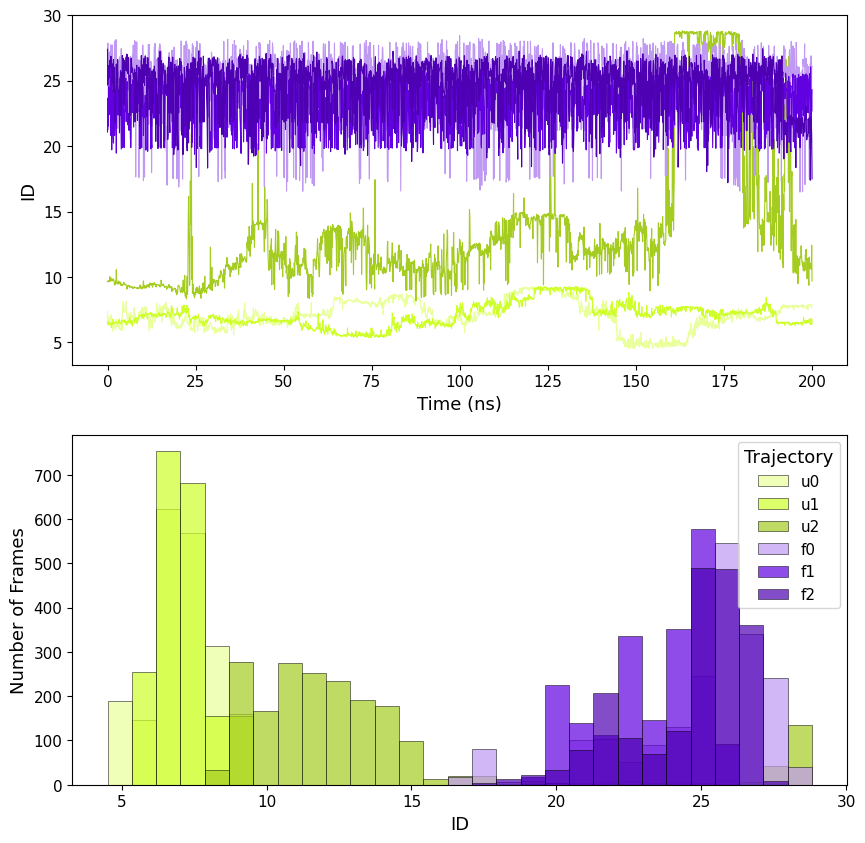

In [3]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
 
#instantaneous id
for i, s in enumerate(data['trajectory']):
    local_id = data.loc[i, 'local_id']
    frames = np.arange(len(local_id))
    time_ns = frames / 10.0  # Convert frames to nanoseconds
    ax[0].plot(time_ns, local_id, color=colors.colors[i], linewidth=0.8)

ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("ID")
      

#####################
#id frequency
all_values = np.concatenate(data['local_id'].values)  # concatenate all local_id arrays
bins = np.linspace(all_values.min(), all_values.max(), 30)

for i, state in enumerate(data['trajectory']):
    local_id = data.loc[i, 'local_id']
    ax[1].hist(local_id, bins=bins, alpha=0.7, label=f"{state}", color=colors.colors[i], edgecolor='black', linewidth=0.5)

ax[1].set_xlabel("ID")
ax[1].set_ylabel("Number of Frames")
ax[1].legend(loc = 'upper right', title = 'Trajectory')
#ax[1].set_title("Frequency")

#fig.legend(bbox_to_anchor=(1.20, 0.5), loc="center right", title='Trajectory')
#plt.savefig(f'../extra/NTL9_instantaneous_{projection_method}.png', dpi=300,bbox_inches='tight')
plt.show()


The trajectories are clearly split in two ID groups, so we can divide the trajectories in "folded" and "unfolded" by setting a threshold at ID<20, this shows the capability of ID to identify the two distinct states. 

This can be done both with ``local`` (including standard deviations) ID and the mean of the ``global`` ID along the trajectory.



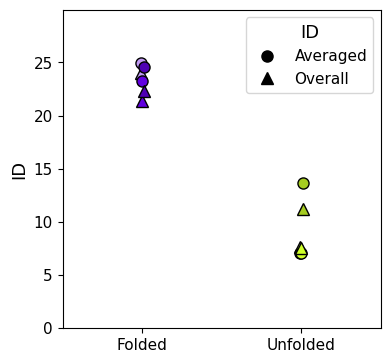

In [19]:
#plot together overall and average 
#compute overall

global_all = []
global_last = []
for state in states:
    gid, gid_last = intrinsic_dimension(topology = topology, trajectory = trajectory+f'_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='global', verbose=False)
    global_all.append(gid)
    global_last.append(gid_last)
data['global_all'] = global_all
data['global_last'] = global_last

threshold_value = 20
fig, ax = plt.subplots(figsize=(4,4))

folded_group = data[data['folded']== True]
unfolded_group = data[data['folded']== False]

groups = [(folded_group, 0, "Folded"), (unfolded_group, 1, "Unfolded")]
shift_amount = 0.01

for group, x_base, label_name in groups:
    n_points = len(group)
    shifts = np.linspace(-shift_amount, shift_amount, n_points)
    for j, (index, row) in enumerate(group.iterrows()):
        x = x_base + shifts[j]
        y = row['mean_all']
        #std_val = np.std(row['local_id'])
        color_idx = states.index(row['trajectory'])  # color by trajectory
        #plt.errorbar(x, y, yerr=std_val,color=colors.colors[color_idx],fmt='o', markeredgecolor='black', ecolor='black', capsize=5, markersize=8,label=f"{row['trajectory']}")
        plt.plot(x, y,marker='o', markersize=8,color=colors.colors[color_idx], markeredgecolor='black') #,label=f"{row['trajectory']}"
        plt.plot(x, row['global_all'],marker='^', markersize=8,color=colors.colors[color_idx], markeredgecolor='black')

        #plt.scatter(x, y,color=colors.colors[color_idx],edgecolor='black',s=64,label=f"{row['trajectory']}")
        
plt.xticks([0, 1], ['Folded', 'Unfolded'])
plt.xlim(-0.5, 1.5)
ax.set_box_aspect(1)
#plt.hlines(y=threshold_value, xmin=-0.5, xmax=1.5,linestyles="--", colors="gray", linewidth=0.5,label="Threshold")
plt.ylabel("ID")
plt.ylim(0, data['mean_all'].max() + 5)

circle_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Averaged')
triangle_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',markersize=8, label='Overall')
plt.legend(handles=[circle_handle, triangle_handle], title='ID', loc='best')

plt.tight_layout()
plt.savefig(f'../extra/ntl9__avg_overall_{projection_method}.pdf', dpi=300)
plt.show()

**sections_id()**


Similarly, with <span class='mark'><code>section_id</code></span>, it is possible to visualise, for each window, the value of ID along the trajectory (both as ``global`` ID and ``local``).

In this case it is intresting to notice how ID differs between replicas and windows, for example replica u2 completely overlaps with the folded values for the first few windows.

In [5]:
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 
projection_method = 'Dihedrals'
all_results = []
for s in states: 
    results = section_id(topology='examples/NTL9/ntl9.pdb', trajectory=f'examples/NTL9/ntl9_{s}.xtc', window_size = 15, stride = 3, projection_method=projection_method, id_method='local', verbose=False)
    results["trajectory"] = s  
    all_results.append(results)
results = pd.concat(all_results, ignore_index=True)
results["folded"] = results["trajectory"].str.startswith("f")
results['window'] = results["start"].astype(str) + "-" + results["end"].astype(str)

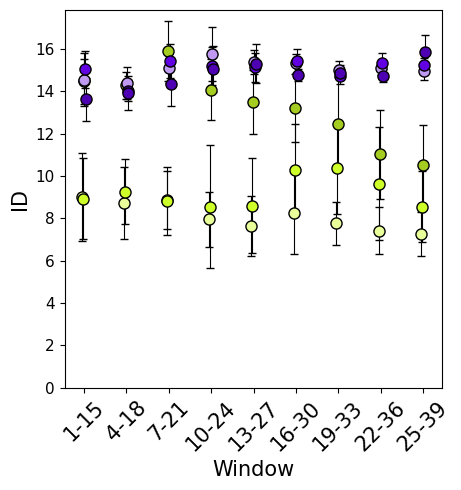

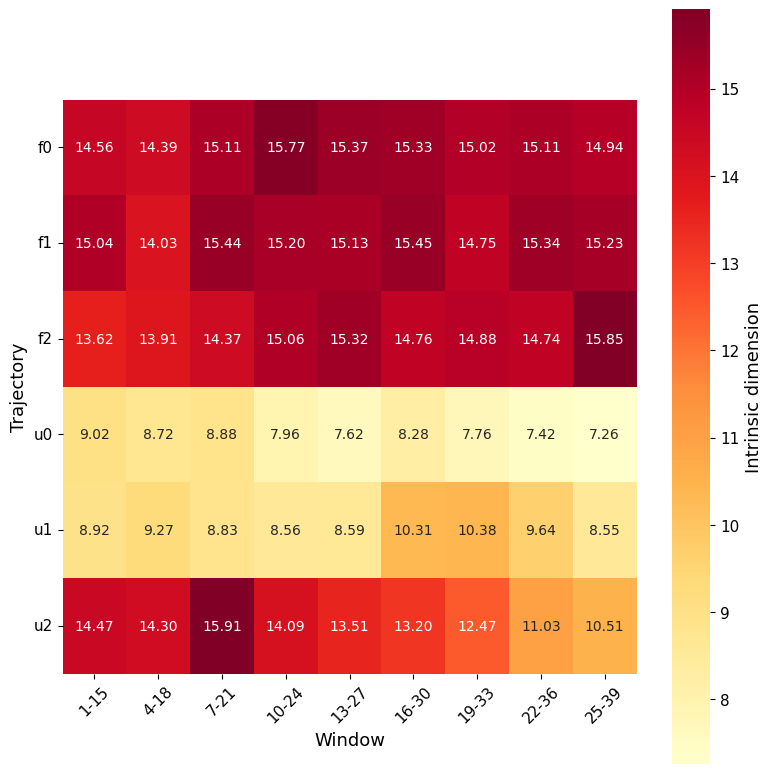

In [6]:
fig, ax= plt.subplots(figsize=(7,5))

shift_amount = 0.05
unique_trajectories = results['trajectory'].unique()
n_traj = len(unique_trajectories)
shifts = np.linspace(-shift_amount, shift_amount, n_traj)

#ID by segment
for i, trajectory in enumerate(unique_trajectories):
    subset = results[results['trajectory'] == trajectory]
    x_labels = subset['window'].values
    x_positions = np.arange(len(x_labels))
    x_shifted = x_positions + shifts[i]
    y_std = subset['instantaneous'].apply(np.std).values
    y = subset['entire simulation'].values

    ax.errorbar(x_shifted, y, yerr=y_std, fmt='o', color=colors.colors[i],markeredgecolor='black', ecolor='black',elinewidth=0.8, capsize=3, markersize=8, label=f"{trajectory}")
    #ax.scatter(x_shifted, y,color=colors.colors[i], edgecolor='black', s=100, label=f"{trajectory}")

ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, fontsize = 15)
ax.set_ylabel("ID", fontsize = 15)
ax.set_xlabel('Window', fontsize = 15)
plt.ylim(0, y.max() + 2)
#ax.legend(title="Trajectory", loc='best')
#ax.legend(title="Trajectory", bbox_to_anchor=(1.25, 0.5), loc='center right') #_2 legenda fuori dal box
ax.set_box_aspect(1)
plt.tight_layout(rect=[0.15, 0, 1, 1])
plt.savefig(f'../extra/ntl9_sections_{projection_method}.pdf', dpi = 300)
plt.show()

#ID heatmap
grouped_data = results.groupby(['trajectory', 'window'], as_index=False)['entire simulation'].mean()
pivot_data = grouped_data.pivot(index='trajectory', columns='window', values='entire simulation')
ordered_cols = sorted(pivot_data.columns, key=lambda w: int(w.split("-")[0]))
pivot_data = pivot_data[ordered_cols]

fig, ax= plt.subplots(figsize=(8,8))
pivot_data.columns.name = None
sns.heatmap(pivot_data, cmap="YlOrRd", annot=True, fmt=".2f", ax=ax, cbar_kws={'label': 'Intrinsic dimension'})
ax.set_ylabel("Trajectory")
ax.set_xlabel('Window')
ax.tick_params(axis='x', rotation=45, labelrotation=45)
ax.tick_params(axis='y', rotation=0)
ax.set_box_aspect(1)
plt.tight_layout()
#plt.savefig(f'../extra/ntl9_sections_heatmap_{projection_method}.pdf', dpi = 300)
plt.show()


**secondary_structure_id()**

<span class='mark'><code>secondary_structure_id</code></span>, divides the protein by secondary structure elements instead of same-length windows, estimating ID along the trajectory on each element individually (both as ``global`` ID and ``local``). 

Computing ID separately for each secondary structure element provides more detailed insights into the protein’s flexibility, as different types of secondary structures comprise distinct levels of flexibility in specific regions.

In [2]:
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 
all_results_ss = []
ss_assignments = []
residue_numbers = None
mol_ref=Molecule('examples/NTL9/ntl9.pdb')
projection_method='Dihedrals'
for s in states:
    results_ss, ss_table = secondary_structure_id(topology='examples/NTL9/ntl9.pdb', trajectory=f'examples/NTL9/ntl9_{s}.xtc', mol_ref = mol_ref, simplified=True, projection_method=projection_method, id_method='local' , verbose=False)
    results_ss['trajectory'] = s  
    if residue_numbers is None:
        residue_numbers = ss_table['resid index'].values
    ss_assignments.append(ss_table['sec str type'].values)
    results_ss['trajectory'] = s   
    all_results_ss.append(results_ss)

results_ss = pd.concat(all_results_ss, ignore_index=True)
results_ss["folded"] = results_ss["trajectory"].str.startswith("f")
results_ss['window'] = results_ss["start"].astype(str) + "-" + results_ss["end"].astype(str)

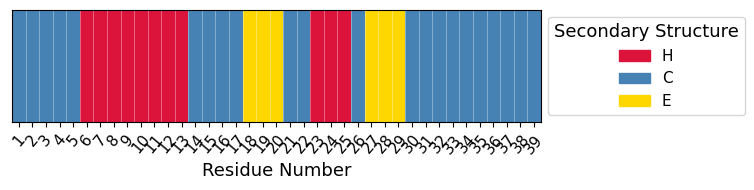

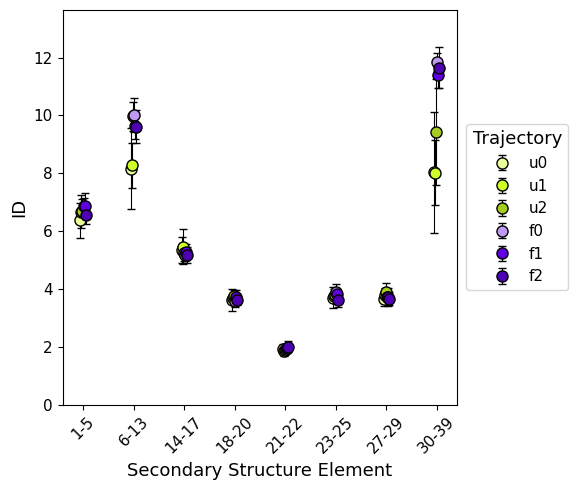

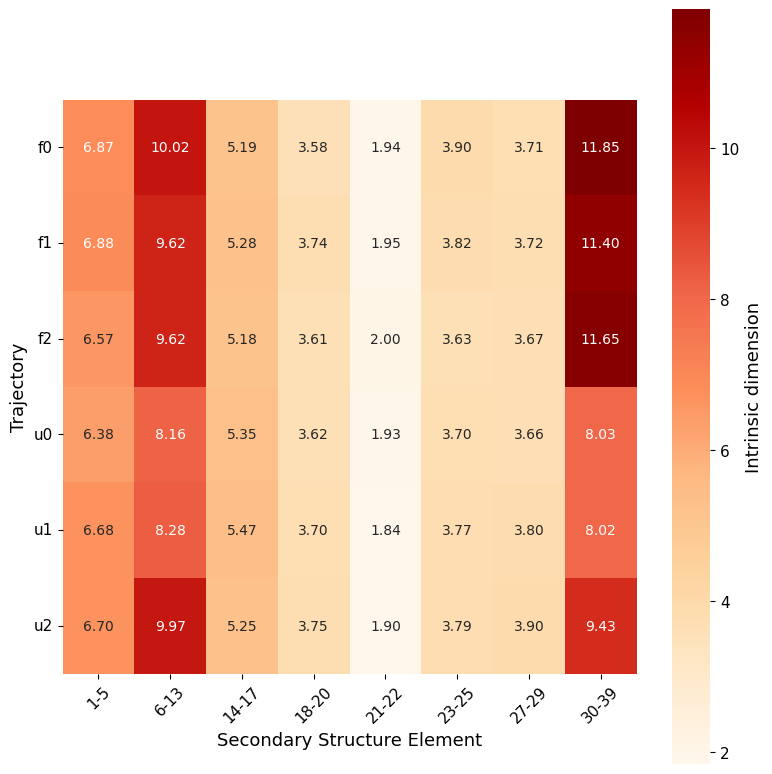

In [3]:

#ss_types = ['H', 'B', 'C', 'E', 'G', 'T', 'S', ' ']
#ss_colors = {"H": "crimson","B": "darkorange", 'C': 'steelblue', "E": "gold", "G": "mediumvioletred","T": "deepskyblue","S": "mediumseagreen", " ": "dimgray"}

#ss of each residue
fig, ax = plt.subplots(figsize=(8, 2))
ss_types = ['H', 'C', 'E']
ss_colors = {"H": "crimson", 'C': 'steelblue', "E": "gold"}

single_ss_assignment = ss_assignments[0] #one result as they are computed from the same structure
ss_to_num = {ss: i for i, ss in enumerate(ss_types)}
num_data = np.array([[ss_to_num[ss] for ss in single_ss_assignment]])
cmap = ListedColormap([ss_colors[ss] for ss in ss_types])
im = ax.imshow(num_data, aspect='auto', cmap=cmap, extent=[residue_numbers[0]-0.5, residue_numbers[-1]+0.5, 0.5, -0.5], vmin=0, vmax=len(ss_types)-1)
for x in np.arange(residue_numbers[0]-0.5, residue_numbers[-1]+1.5, 1):
    ax.axvline(x=x, color='white', linewidth=0.5, alpha=0.5)
for y in [-0.5, 0.5]:
    ax.axhline(y=y, color='white', linewidth=0.5, alpha=0.5)
ax.grid(False)
ax.set_xticks(residue_numbers)
ax.set_yticks([])
ax.set_xlabel('Residue Number')
ax.tick_params(axis='x', rotation=50)  

legend_elements = [plt.Rectangle((0,0), 1, 1, color=ss_colors[ss], label=ss) for ss in ss_types]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.40, 0.5), loc='center right', title='Secondary Structure')

plt.tight_layout()
#plt.savefig('../extra/ntl9_ss_residues.pdf', dpi=300)
plt.show()

#ID distribution
fig, ax = plt.subplots(figsize=(7,5))
shift_amount = 0.05
unique_trajectories = results_ss['trajectory'].unique()
n_traj = len(unique_trajectories)
shifts = np.linspace(-shift_amount, shift_amount, n_traj)

for i, trajectory in enumerate(unique_trajectories):
    subset = results_ss[results_ss['trajectory'] == trajectory]
    x_labels = subset['window'].values
    x_positions = np.arange(len(x_labels))
    x_shifted = x_positions + shifts[i]
    y_std = subset['instantaneous'].apply(np.std).values
    y = subset['entire simulation'].values

    ax.errorbar(x_shifted, y, yerr=y_std, fmt='o', color=colors.colors[i],markeredgecolor='black', ecolor='black',elinewidth=0.8, capsize=3, markersize=8, label=f"{trajectory}")
    #ax.scatter(x_shifted, y,color=colors.colors[i], edgecolor='black', s=100, label=f"{trajectory}")

all_windows = sorted(results_ss['window'].unique(), key=lambda w: int(w.split("-")[0]))
window_to_position = {window: pos for pos, window in enumerate(all_windows)}
ax.set_xticks(np.arange(len(all_windows)))
ax.set_xticklabels(all_windows, rotation=45)
plt.ylim(0, y.max() + 2)
#ax.set_yticks([])
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("ID")
ax.set_xlabel("Secondary Structure Element")
ax.set_box_aspect(1)
ax.legend(title="Trajectory", loc='center right',  bbox_to_anchor=(1.30, 0.5))
#ax.legend(title="Trajectory", loc='upper left')

plt.tight_layout(rect=[0.15, 0, 1, 1])
plt.savefig(f'../extra/ntl9_ss_{projection_method}.pdf', dpi=300)
plt.show()

#ID value
fig, ax = plt.subplots(figsize=(8, 8))

grouped_data = results_ss.groupby(['trajectory', 'window'], as_index=False)['entire simulation'].mean()
pivot_data = grouped_data.pivot(index='trajectory', columns='window', values='entire simulation')
ordered_cols = sorted(pivot_data.columns, key=lambda w: int(w.split("-")[0]))
pivot_data = pivot_data[ordered_cols]
pivot_data.columns.name = None
sns.heatmap(pivot_data, cmap="OrRd", annot=True, fmt=".2f", ax=ax, cbar_kws={'label': 'Intrinsic dimension'})
ax.set_ylabel("Trajectory")
ax.set_xlabel("Secondary Structure Element")
ax.tick_params(axis='x', rotation=45, labelrotation=45)
ax.tick_params(axis='y', rotation=0)
ax.set_box_aspect(1)
plt.tight_layout()
#plt.savefig(f'../extra/ntl9_ss_heatmap_{projection_method}.pdf', dpi=300)
plt.show()
